In [ ]:
# import subprocess
# import sys

# def install_additional_packages():
#     # sklearn, pandas, lightgbm은 이미 설치되어 있다고 가정
#     packages = [
#         "numpy",
#         "matplotlib",
#         "seaborn",
#         "xgboost",
#         "catboost",
#         "optuna",
#         "tqdm",
#         "torch",
#         "requests",
#     ]
    
#     for package in packages:
#         subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# # 실행
# install_additional_packages()


In [1]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
#EDA
# train.head(5)
# train.info()
# train.isnull().sum()
# test.isnull().sum()
# train.head(5)

#전처리
train = train.drop(["ID"], axis=1)
test2 = test.pop("ID")
target = train.pop('stress_score')


train['BMI'] = train['weight'] / ((train['height'] / 100) ** 2)
test['BMI'] = test['weight'] / ((test['height'] / 100) ** 2)




# 근무시간 구간화
def working_group(x):
    if x < 5:
        return 'short'
    elif x < 10:
        return 'normal'
    else:
        return 'long'

train['working_label'] = train['mean_working'].apply(working_group)
test['working_label'] = test['mean_working'].apply(working_group)

# 순서 인코딩
working_map = {'short': 0, 'normal': 1, 'long': 2}

train['working_encoded'] = train['working_label'].map(working_map)
test['working_encoded'] = test['working_label'].map(working_map)

train = train.drop(['working_label'], axis=1)
test = test.drop(['working_label'], axis=1)
# # 수면 + 근무 조합
# train['work_sleep_combo'] = train['sleep_pattern'] + '_' + train['working_label']
# test['work_sleep_combo'] = test['sleep_pattern'] + '_' + test['working_label']
# train = train.drop(["working_label"], axis=1)
# test = test.drop(['working_label'], axis=1)

#결측치 처리
train['family_medical_history'] = train['family_medical_history'].fillna(0)
train['medical_history'] =train['medical_history'].fillna(0)
test['family_medical_history'] = test['family_medical_history'].fillna(0)
test['medical_history'] =test['medical_history'].fillna(0)

train['edu_level'] = train['edu_level'].fillna(train['edu_level'].mode()[0])
test['edu_level'] = test['edu_level'].fillna(test['edu_level'].mode()[0])

train['mean_working'].fillna(0, inplace=True)
test['mean_working'].fillna(0, inplace=True)

#0을 'none'으로 바꾸기
train['medical_history'] = train['medical_history'].replace(0, 'none')
test['medical_history'] = test['medical_history'].replace(0, 'none')

train['family_medical_history'] = train['family_medical_history'].replace(0, 'none')
test['family_medical_history'] = test['family_medical_history'].replace(0, 'none')




cols = train.select_dtypes(include='O').columns
#cols

# 1. Label Encoding ------------------------

# gender: F=0, M=1
gender_map = {'F': 0, 'M': 1}
train['gender_encoded'] = train['gender'].map(gender_map)
test['gender_encoded'] = test['gender'].map(gender_map)

# activity: light=0, moderate=1, intense=2
activity_map = {'light': 0, 'moderate': 1, 'intense': 2}
train['activity_encoded'] = train['activity'].map(activity_map)
test['activity_encoded'] = test['activity'].map(activity_map)


# 2. One-Hot Encoding ----------------------

cols_ohe = ['smoke_status', 'sleep_pattern', 'medical_history', 'family_medical_history']

# train과 test에 각각 One-Hot Encoding
train = pd.get_dummies(train, columns=cols_ohe, drop_first=True)
test = pd.get_dummies(test, columns=cols_ohe, drop_first=True)

# 3. 원본 컬럼 제거 ------------------------

cols_to_drop = ['gender', 'activity']
train.drop(columns=cols_to_drop, inplace=True)
test.drop(columns=cols_to_drop, inplace=True)

# 4. train/test 컬럼 맞추기 ----------------
# 만약 train과 test에 One-Hot 결과가 달라질 수도 있으므로
# 이를 자동으로 맞춰주는 코드 (중요!)

# 누락된 열 보완
missing_cols = set(train.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0

missing_cols = set(test.columns) - set(train.columns)
for col in missing_cols:
    train[col] = 0

# 열 순서 맞추기
test = test[train.columns]



edu2 = {
    'high school diploma': 0,
    'bachelors degree': 1,
    'graduate degree': 2
}
train['edu_level'] = train['edu_level'].map(edu2)
test['edu_level'] = test['edu_level'].map(edu2)

from sklearn.preprocessing import LabelEncoder


#파생변수 추가
# Disease Any: 만성질환/가족력 중 하나라도 있으면 1
train['disease_any'] = (
    (train.filter(like='medical_history_').sum(axis=1) > 0) |
    (train.filter(like='family_medical_history_').sum(axis=1) > 0)
).astype(int)

test['disease_any'] = (
    (test.filter(like='medical_history_').sum(axis=1) > 0) |
    (test.filter(like='family_medical_history_').sum(axis=1) > 0)
).astype(int)




#스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
test = pd.DataFrame(scaler.transform(test), columns=test.columns)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(train,target,test_size=0.25,stratify=target,random_state=0)

# 이상치 처리
def clip_outliers_iqr(df, columns, factor=1.5):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        num_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
        print(f"{col}: 이상치 {num_outliers}개 (clip 적용)")
        df[col] = df[col].clip(lower, upper)
    return df

num_cols = [
    'age', 'height', 'weight', 'cholesterol',
    'systolic_blood_pressure', 'diastolic_blood_pressure',
    'glucose', 'bone_density', 'mean_working', 'BMI'
]

train = clip_outliers_iqr(train, num_cols)
test = clip_outliers_iqr(test, num_cols)


#교차검증
# from xgboost import XGBRegressor
# from sklearn.model_selection import GridSearchCV

# # XGBoost 회귀 모델
# xgb = XGBRegressor(random_state=0, objective='reg:squarederror') #목적함수

# # 하이퍼파라미터 그리드 설정
# params = {
#     'n_estimators': [100, 300, 500],     # 트리 개수
#     'learning_rate': [0.05, 0.1],        # 학습률
#     'max_depth': [3, 6]                  # 트리 최대 깊이
# }

# # GridSearchCV 설정 - MAE 기준
# grid = GridSearchCV(estimator=xgb,
#                     param_grid=params,
#                     scoring='neg_mean_absolute_error',  # MAE 사용
#                     cv=5,
#                     n_jobs=-1,
#                     verbose=1)

# # 학습
# grid.fit(x_train, y_train)

# # 결과 출력
# print("최적 하이퍼파라미터:", grid.best_params_)
# print("교차검증 평균 MAE:", -grid.best_score_)  # neg_mean_absolute_error → 부호 뒤집어야 함(최소값 찾아야하므로)

# 최적 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}
# 교차검증 평균 MAE: 0.20141168113412955

from xgb import XGBRegressor
from sklearn.metrics import mean_absolute_error

# 최적 하이퍼파라미터 기반 모델 생성
xgb_best = XGBRegressor(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=500,
    objective='reg:squarederror',  # 회귀용 목적 함수
    random_state=0,
    n_jobs=-1 #cpu코어 사용
)

# 모델 학습
xgb_best.fit(x_train, y_train)

# 예측
pred = xgb_best.predict(x_test)

# MAE 계산
mae = mean_absolute_error(y_test, pred)
print(" MAE:", mae)

#test데이터 예측
pred = xgb_best.predict(test)

result = pd.DataFrame({'ID':test2,"stress_score":pred})
result.to_csv("submission3.csv",index=False)
pd.read_csv('submission3.csv')        

#교차검증
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
a = cross_val_score(xgb_best, x_train, y_train, cv=5, scoring=mae_scorer)

print("각 5번 MAE 점수:", -a) 
#[0.21126256 0.19372368 0.19983671 0.19985151 0.20238396]
#0.1960837715413918 - 이상치 처리
# MAE: 0.1960837715413918
#각 5번 MAE 점수: [0.20400829 0.1947348  0.20041159 0.19832888 0.20523938]

C:\Users\seong\AppData\Local\Temp\ipykernel_15524\3645336844.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['mean_working'].fillna(0, inplace=True)
C:\Users\seong\AppData\Local\Temp\ipykernel_15524\3645336844.py:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

age: 이상치 0개 (clip 적용)
height: 이상치 1개 (clip 적용)
weight: 이상치 2개 (clip 적용)
cholesterol: 이상치 17개 (clip 적용)
systolic_blood_pressure: 이상치 2개 (clip 적용)
diastolic_blood_pressure: 이상치 19개 (clip 적용)
glucose: 이상치 13개 (clip 적용)
bone_density: 이상치 0개 (clip 적용)
mean_working: 이상치 0개 (clip 적용)
BMI: 이상치 19개 (clip 적용)
age: 이상치 0개 (clip 적용)
height: 이상치 2개 (clip 적용)
weight: 이상치 13개 (clip 적용)
cholesterol: 이상치 22개 (clip 적용)
systolic_blood_pressure: 이상치 9개 (clip 적용)
diastolic_blood_pressure: 이상치 5개 (clip 적용)
glucose: 이상치 11개 (clip 적용)
bone_density: 이상치 0개 (clip 적용)
mean_working: 이상치 0개 (clip 적용)
BMI: 이상치 13개 (clip 적용)
 MAE: 0.18222416384975115
각 5번 MAE 점수: [0.20730009 0.20654469 0.19736418 0.19841112 0.20035276]


In [ ]:
train.info()
# --- gender ---
# gender
# F    1508
# M    1492
# Name: count, dtype: int64

# --- activity ---
# activity
# moderate    1431
# light        894
# intense      675
# Name: count, dtype: int64

# --- smoke_status ---
# smoke_status
# ex-smoker         1177
# non-smoker        1039
# current-smoker     784
# Name: count, dtype: int64

# --- sleep_pattern ---
# sleep_pattern
# normal              1557
# sleep difficulty    1019
# oversleeping         424
# --- medical_history ---
# medical_history
# none                   1289
# high blood pressure     697
# heart disease           508
# diabetes                506
# Name: count, dtype: int64

# --- family_medical_history ---
# family_medical_history
# none                   1486
# diabetes                615
# high blood pressure     480
# heart disease           419

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 34 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   age                                         3000 non-null   int64  
 1   height                                      3000 non-null   float64
 2   weight                                      3000 non-null   float64
 3   cholesterol                                 3000 non-null   float64
 4   systolic_blood_pressure                     3000 non-null   float64
 5   diastolic_blood_pressure                    3000 non-null   float64
 6   glucose                                     3000 non-null   float64
 7   bone_density                                3000 non-null   float64
 8   edu_level                                   3000 non-null   int64  
 9   mean_working                                3000 non-null   float64
 10  BMI         

In [34]:
from sklearn.model_selection import cross_val_score

# MAE (음수로 바꾸기)-mae와 rmse차이가 크면 예측 실패
mae_scores = -cross_val_score(xgb_best, x_train, y_train, scoring='neg_mean_absolute_error', cv=5)
rmse_scores = np.sqrt(-cross_val_score(xgb_best, x_train, y_train, scoring='neg_mean_squared_error', cv=5))
r2_scores = cross_val_score(xgb_best, x_train, y_train, scoring='r2', cv=5)

print(f"MAE     (cv5 mean): {mae_scores.mean():.4f}")
print(f"RMSE    (cv5 mean): {rmse_scores.mean():.4f}")
print(f"R^2     (cv5 mean): {r2_scores.mean():.4f}")


MAE     (cv5 mean): 0.2020
RMSE    (cv5 mean): 0.2637
R^2     (cv5 mean): 0.1581


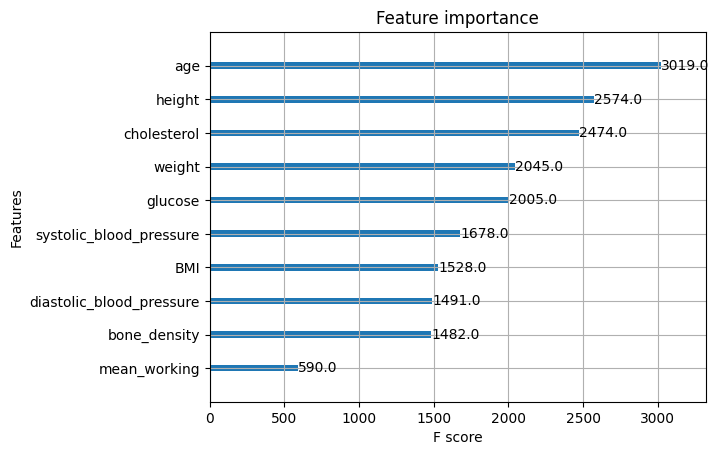

In [38]:
# train.head()#다중공산성
# plt.figure(figsize=(20,20))
# sns.heatmap(train.corr(),fmt='.2f',annot=True,cmap='Greens')
# plt.show()

#xgb boost 중요도피처확인
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(xgb_best, max_num_features=10)
plt.show()

<Figure size 1500x3000 with 0 Axes>

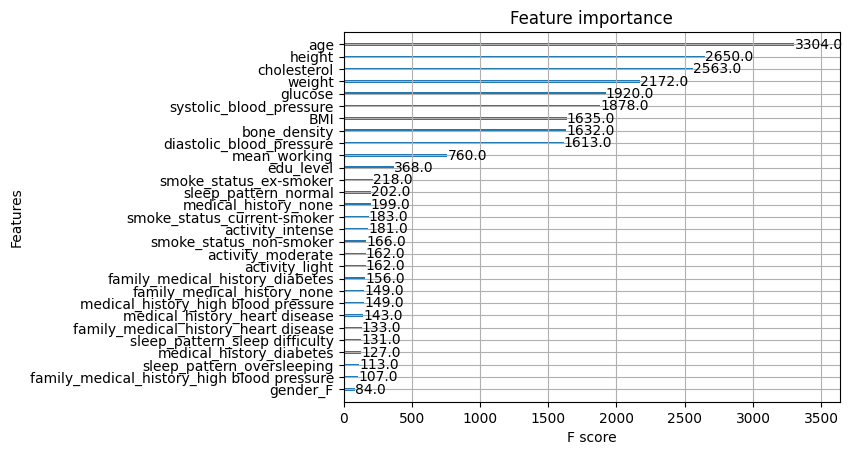

In [8]:
#중요도 시각화
import matplotlib.pyplot as plt
from xgboost import plot_importance
plt.figure(figsize=(15,30))
plot_importance(xgb_best, max_num_features=31)
plt.show()

# cols = train.select_dtypes(include='O').columns
# cols
# #'gender', 'activity', 'smoke_status', 'medical_history',
#        #'family_medical_history', 'sleep_pattern', 'edu_level'
# for col in cols:
#     print(f"\n{col} unique values:", train[col].unique())

# for col in ['gender', 'activity', 'smoke_status', 'medical_history',
#             'family_medical_history', 'sleep_pattern', 'edu_level']:
#     print(f"\n{col} unique values:", train[col].unique())

# train['mean_working'].unique()

In [21]:
# 캣부스트
# from catboost import CatBoostRegressor
# from sklearn.metrics import mean_absolute_error

# # CatBoost 회귀 모델 생성
# cat_model = CatBoostRegressor(
#     iterations=500,
#     learning_rate=0.1,
#     depth=6,
#     loss_function='MAE',       # MAE(Mean Absolute Error)로 설정
#     random_seed=0,
#     verbose=100                # 학습 진행 상황 출력
# )

# # 모델 학습
# cat_model.fit(x_train, y_train)

# # 예측
# cat_pred = cat_model.predict(x_test)

# # 성능 평가
# cat_mae = mean_absolute_error(y_test, cat_pred)
# print("CatBoost MAE:", cat_mae)

train.head()




AttributeError: 'numpy.ndarray' object has no attribute 'head'